In [ ]:
!pip install geopandas
!pip install planetary_computer
!pip install pystac_client
!pip install rioxarray
!pip install xarray

In [21]:
import geopandas
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import pystac_client
import rioxarray
import xarray as xr

In [61]:
bounding_box = [-97.159138,32.149164,-97.134418,32.165005]

start = pd.Timestamp("2021-10-10T13:00:00Z")
stop = pd.Timestamp("2021-10-11T15:40:00Z")

In [62]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
search = catalog.search(
    collections=["goes-cmi"],
    bbox=bounding_box,
    datetime=[start, stop],
    limit=500,
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)
items = search.get_all_items()
signed_items = sorted(
    [planetary_computer.sign(item) for item in items], key=lambda x: x.datetime
)

In [ ]:
bands = ["C01_2km", "C02_2km", "C03_2km"]
common_names = [items[0].assets[band].extra_fields["eo:bands"][0]["common_name"] for band in bands]
time = xr.DataArray(
    pd.to_datetime([x.datetime for x in signed_items]).tz_localize(None),
    name="time",
    dims=["time"],
)
arrays = [
    xr.concat(
        [rioxarray.open_rasterio(item.assets[band].href) for band in bands], dim="band"
    ).assign_coords(band=common_names)
    for item in signed_items[0:100]
]

In [66]:
arrays[0]

<xarray.DataArray 'CMI_C01' (band: 3, y: 500, x: 500)>
array([[[  4,   4,   4, ..., 334, 332, 337],
        [  3,   3,   4, ..., 322, 329, 340],
        [  4,   4,   3, ..., 321, 321, 325],
        ...,
        [ 76,  76,  75, ..., 175, 175, 175],
        [ 76,  76,  75, ..., 176, 175, 175],
        [ 75,  76,  76, ..., 176, 175, 176]],

       [[  3,   1,   3, ..., 263, 262, 266],
        [  2,   0,   3, ..., 252, 258, 269],
        [  2,   0,   2, ..., 253, 251, 255],
        ...,
        [ 37,  35,  35, ...,  58,  58,  59],
        [ 37,  34,  35, ...,  60,  58,  60],
        [ 37,  35,  36, ...,  60,  58,  61]],

       [[  3,   3,   2, ..., 311, 308, 310],
        [  3,   2,   3, ..., 296, 303, 317],
        [  0,   0,   1, ..., 295, 293, 295],
        ...,
        [ 48,  40,  47, ...,  28,  27,  27],
        [ 56,  39,  40, ...,  27,  27,  26],
        [ 61,  46,  44, ...,  27,  27,  29]]], dtype=int16)
Coordinates:
  * band                    (band) <U5 'blue' 'red' 'nir09'
  * x                       (x) float64 -2.424e+06 -2.422e+06 ... -1.424e+06
  * y                       (y) float64 3.927e+06 3.925e+06 ... 2.927e+06
    goes_imager_projection  int64 0
Attributes: (12/14)
    add_offset:             0.0
    ancillary_variables:    DQF_C01
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    coordinates:            band_id_C01 band_wavelength_C01 t y x
    downsampling_method:    average
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    ...                     ...
    sensor_band_bit_depth:  10
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    units:                  1
    valid_range:            [   0. 4095.]
    _FillValue:             -1.0
    _Unsigned:              true

In [68]:
data = xr.concat(arrays, dim='add_offset').rename("goes")
data

<xarray.DataArray 'goes' (add_offset: 100, band: 3, y: 500, x: 500)>
array([[[[  4,   4,   4, ..., 334, 332, 337],
         [  3,   3,   4, ..., 322, 329, 340],
         [  4,   4,   3, ..., 321, 321, 325],
         ...,
         [ 76,  76,  75, ..., 175, 175, 175],
         [ 76,  76,  75, ..., 176, 175, 175],
         [ 75,  76,  76, ..., 176, 175, 176]],

        [[  3,   1,   3, ..., 263, 262, 266],
         [  2,   0,   3, ..., 252, 258, 269],
         [  2,   0,   2, ..., 253, 251, 255],
         ...,
         [ 37,  35,  35, ...,  58,  58,  59],
         [ 37,  34,  35, ...,  60,  58,  60],
         [ 37,  35,  36, ...,  60,  58,  61]],

        [[  3,   3,   2, ..., 311, 308, 310],
         [  3,   2,   3, ..., 296, 303, 317],
         [  0,   0,   1, ..., 295, 293, 295],
         ...,
...
         ...,
         [310, 306, 296, ..., 340, 321, 388],
         [312, 305, 296, ..., 335, 414, 333],
         [313, 317, 300, ..., 331, 370, 407]],

        [[208, 199, 206, ..., 805, 815, 807],
         [207, 190, 208, ..., 822, 795, 791],
         [216, 201, 202, ..., 857, 845, 840],
         ...,
         [202, 185, 167, ..., 139, 117, 198],
         [203, 186, 161, ..., 124, 220, 133],
         [205, 211, 169, ..., 130, 182, 211]],

        [[291, 277, 293, ..., 903, 915, 914],
         [292, 268, 291, ..., 928, 903, 899],
         [293, 276, 278, ..., 968, 964, 960],
         ...,
         [432, 455, 441, ...,  96,  70, 175],
         [456, 476, 442, ...,  92, 213,  83],
         [472, 472, 448, ...,  87, 149, 202]]]], dtype=int16)
Coordinates:
  * band                    (band) <U5 'blue' 'red' 'nir09'
  * x                       (x) float64 -2.424e+06 -2.422e+06 ... -1.424e+06
  * y                       (y) float64 3.927e+06 3.925e+06 ... 2.927e+06
    goes_imager_projection  int64 0
Dimensions without coordinates: add_offset
Attributes: (12/14)
    add_offset:             0.0
    ancillary_variables:    DQF_C01
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    coordinates:            band_id_C01 band_wavelength_C01 t y x
    downsampling_method:    average
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    ...                     ...
    sensor_band_bit_depth:  10
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    units:                  1
    valid_range:            [   0. 4095.]
    _FillValue:             -1.0
    _Unsigned:              true

In [69]:
green = (
    0.45 * data.sel(band="red")
    + 0.1 * data.sel(band="nir09")
    + 0.45 * data.sel(band="blue")
).assign_coords(band="green")
green

<xarray.DataArray 'goes' (add_offset: 100, y: 500, x: 500)>
array([[[  3.45,   2.55,   3.35, ..., 299.75, 298.1 , 302.35],
        [  2.55,   1.55,   3.45, ..., 287.9 , 294.45, 305.75],
        [  2.7 ,   1.8 ,   2.35, ..., 287.8 , 286.7 , 290.5 ],
        ...,
        [ 55.65,  53.95,  54.2 , ..., 107.65, 107.55, 108.  ],
        [ 56.45,  53.4 ,  53.5 , ..., 108.9 , 107.55, 108.35],
        [ 56.5 ,  54.55,  54.8 , ..., 108.9 , 107.55, 109.55]],

       [[  3.8 ,   2.65,   3.45, ..., 300.55, 304.65, 297.95],
        [  3.55,   2.65,   3.8 , ..., 303.1 , 296.  , 296.95],
        [  3.15,   2.35,   3.15, ..., 298.2 , 290.35, 281.1 ],
        ...,
        [ 58.3 ,  56.05,  56.3 , ..., 107.45, 108.  , 109.55],
        [ 59.  ,  56.5 ,  56.05, ..., 109.35, 108.45, 109.45],
        [ 59.6 ,  57.65,  57.35, ..., 109.9 , 109.45, 111.9 ]],

       [[  3.35,   3.  ,   3.55, ..., 311.85, 311.75, 308.35],
        [  2.45,   3.1 ,   3.55, ..., 304.1 , 313.35, 306.7 ],
        [  2.35,   2.9 ,   3.35, ..., 301.1 , 299.7 , 299.6 ],
        ...,
...
        ...,
        [270.1 , 262.1 , 249.15, ..., 244.8 , 212.3 , 259.2 ],
        [272.95, 266.05, 248.35, ..., 243.45, 309.8 , 202.1 ],
        [276.25, 280.95, 254.7 , ..., 227.8 , 270.9 , 242.75]],

       [[262.4 , 259.8 , 261.9 , ..., 886.7 , 868.6 , 868.55],
        [263.45, 253.5 , 263.6 , ..., 875.7 , 852.05, 851.05],
        [266.1 , 260.3 , 258.35, ..., 905.3 , 906.15, 880.8 ],
        ...,
        [270.95, 264.5 , 249.8 , ..., 234.2 , 206.4 , 271.65],
        [275.25, 267.8 , 249.85, ..., 224.1 , 310.05, 212.75],
        [278.1 , 283.05, 257.3 , ..., 221.5 , 265.35, 267.75]],

       [[265.35, 260.35, 266.45, ..., 875.55, 886.2 , 878.9 ],
        [265.9 , 254.5 , 268.05, ..., 894.7 , 870.6 , 863.  ],
        [271.4 , 261.6 , 261.8 , ..., 929.75, 919.9 , 915.  ],
        ...,
        [273.6 , 266.45, 252.45, ..., 225.15, 204.1 , 281.2 ],
        [277.35, 268.55, 249.85, ..., 215.75, 306.6 , 218.  ],
        [280.3 , 284.8 , 255.85, ..., 216.15, 263.3 , 298.3 ]]])
Coordinates:
  * x                       (x) float64 -2.424e+06 -2.422e+06 ... -1.424e+06
  * y                       (y) float64 3.927e+06 3.925e+06 ... 2.927e+06
    goes_imager_projection  int64 0
    band                    <U5 'green'
Dimensions without coordinates: add_offset

In [70]:
γ = 2.2

rgb = xr.concat([data, green], dim="band").sel(band=["red", "green", "blue"])
rgb = rgb / rgb.max(dim=["band", "y", "x"])
rgb = np.clip(rgb ** (1 / γ), 0, 1)

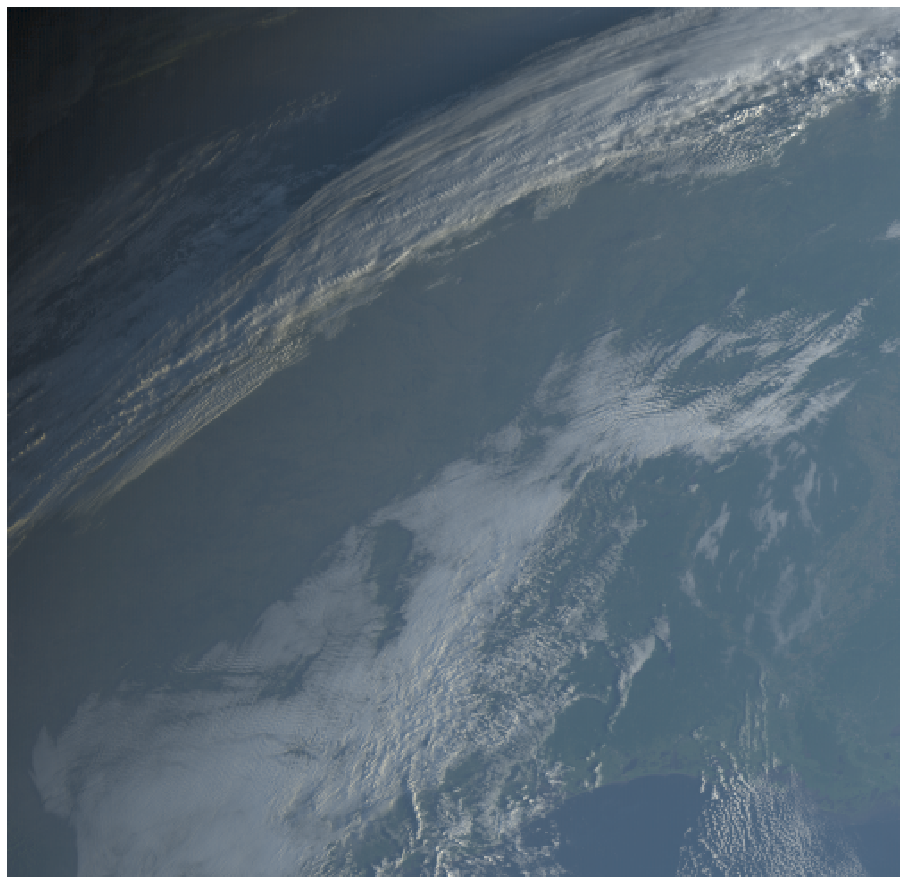

In [73]:
fig, ax = plt.subplots(figsize=(16, 16))
rgb.isel(add_offset=0).plot.imshow(rgb="band", add_labels=False)
ax.set_axis_off()

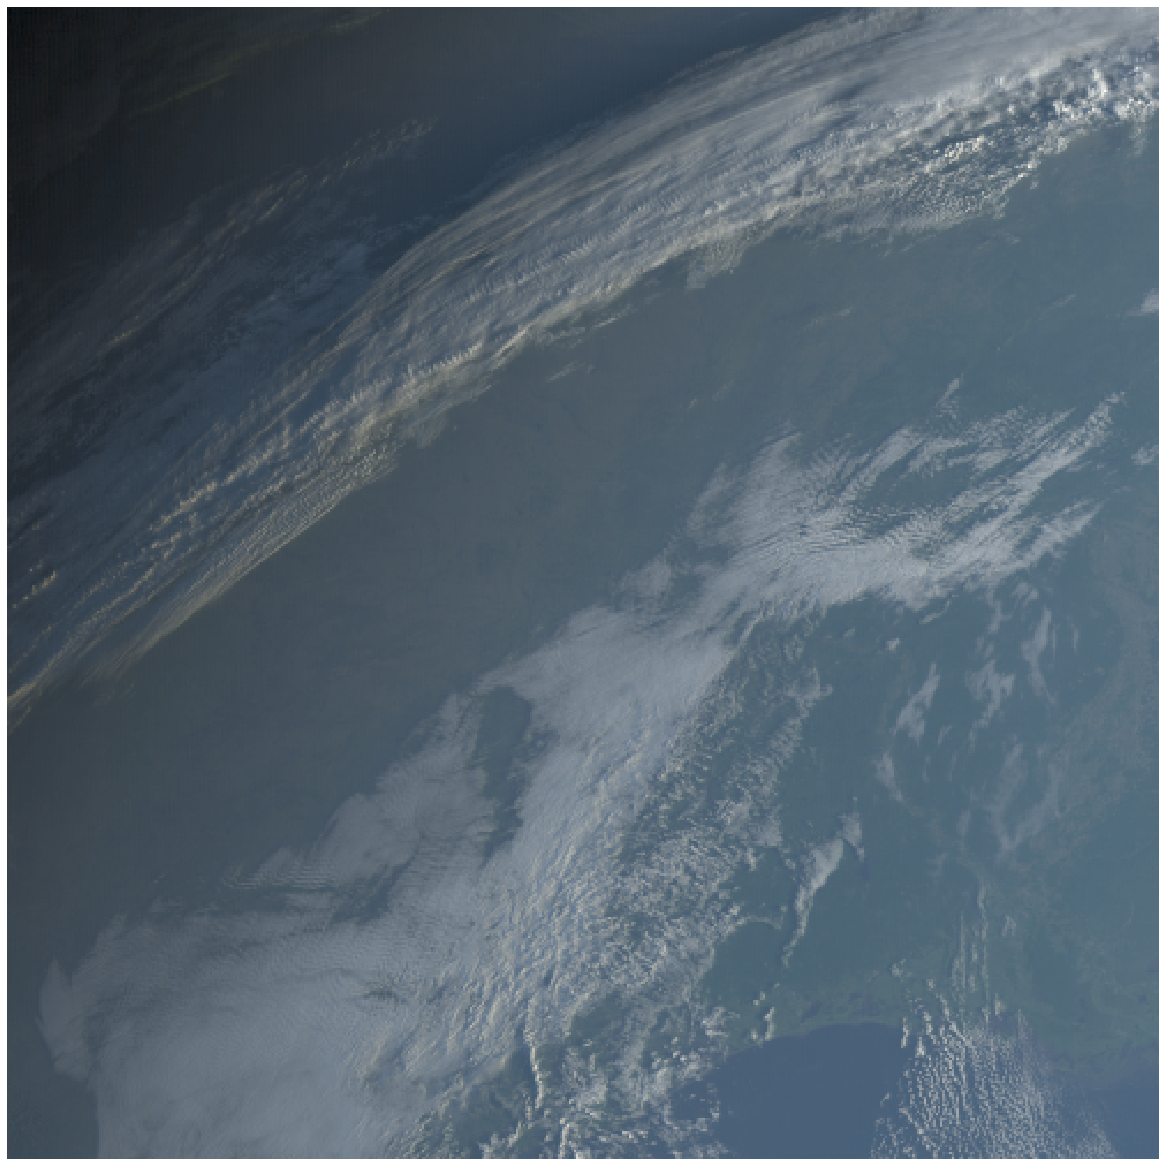

In [74]:
fig, ax = plt.subplots(figsize=(16, 16))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_axis_off()

img = rgb[0].plot.imshow(ax=ax, add_colorbar=False, rgb="band", add_labels=False)

def animate(i):
    img.set_data(rgb[i].transpose("y", "x", "band"))
    return img


ani = animation.FuncAnimation(fig, animate, frames=len(rgb), interval=120)
ani.save(
    "itasca.mp4",
    fps=15,
    extra_args=["-vcodec", "libx264"],
    savefig_kwargs=dict(pad_inches=0, transparent=True),
)